# Airline Twitter Sentiment: SVM Classification

### Loading and Preparing the Data

In [0]:
import pandas as pd
import numpy as np
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [0]:

# Training Set:
!gdown https://drive.google.com/uc?id=1BLT_kqE1Uz0-NNDU1_BfoSPyV_EXGOxT
# Test Set:
!gdown https://drive.google.com/uc?id=1bF3gAkMFprumMgRWoNW3PFWXsxBY1Fqj


Downloading...
From: https://drive.google.com/uc?id=1BLT_kqE1Uz0-NNDU1_BfoSPyV_EXGOxT
To: /content/Tweet_Train_Set.xlsx
100% 1.22M/1.22M [00:00<00:00, 73.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bF3gAkMFprumMgRWoNW3PFWXsxBY1Fqj
To: /content/Tweet_Test_Set.xlsx
100% 535k/535k [00:00<00:00, 79.2MB/s]


In [0]:
%ls

sample_data/               svm_raw_grid_results.csv  Tweet_Train_Set.xlsx
slang_list.txt             Tweets.csv
svm_raw_grid_results2.csv  Tweet_Test_Set.xlsx


In [0]:
tweets_train = pd.read_excel('Tweet_Train_Set.xlsx', encoding='UTF-8')
tweets_test = pd.read_excel('Tweet_Test_Set.xlsx', encoding='UTF-8')

In [0]:
def preprocess(tweets):

  import nltk
  from nltk.stem import SnowballStemmer, PorterStemmer
  from nltk.tokenize import word_tokenize
  from nltk.corpus import stopwords
  
  nltk.download('stopwords')
  nltk.download('punkt')
  
  ss = SnowballStemmer('english')
  
  tweets['punct_removed'] = tweets['text'].str.replace(r'@\w+', r'at_user')
  tweets['punct_removed'] = tweets['punct_removed'].str.replace(r"http\S+", r'')
  
  tweets['punct_removed'] = tweets['punct_removed'].str.replace(r'[^a-zA-Z0-9!)\( ]',r'')
  
  
  tweets['punct_removed'] = tweets['punct_removed'].str.lower()
  tweets['tokenized'] = tweets['punct_removed'].apply(word_tokenize)
  
  stops = stopwords.words('english')
  tweets['tokenized'] = tweets['tokenized'].apply(lambda x: [item for item in x if item not in stops])

  tweets['stemmed'] = tweets['tokenized'].apply(lambda x: [ss.stem(y) for y in x])

  
  return tweets




In [0]:
tweets_train = preprocess(tweets_train)
tweets_test = preprocess(tweets_test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

In [0]:
def do_nothing(input):
  return input

cv = CountVectorizer(preprocessor = do_nothing,
                             tokenizer = do_nothing,
                             analyzer = do_nothing)
                      

In [0]:
X_train = cv.fit_transform(tweets_train['stemmed'])
X_test = cv.transform(tweets_test['stemmed'])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_labels = tweets_train['airline_sentiment']
test_labels = tweets_test['airline_sentiment']

y_train = le.fit_transform(train_labels)
y_test = le.transform(test_labels)

In [0]:
#example of creating and training a SVM classifier
clf = SVC(C=2, kernel = 'rbf', gamma = 0.08)

In [0]:
clf.fit(X_train, y_train)


SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.08, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
clf.score(X_train, y_train)


0.9540507859733979

In [0]:
clf.score(X_test,y_test)


0.7320169252468265

## Grid Searching

Grid searching checks a "grid" or matrix of possible values for multiple hyperparameters. The SVM with RBF kernel can take the regularization hyperparameter 'C' and the hyperparameter "gamma" for its Gaussian kernel. To optimize both of these together, we have to test them in combinations. 

These tests should not use the Test set to evaluate performance, because our Test results would not be truly independent if we have chosen hyperparameters based on the Test set.

Instead, we use k-Fold cross validation of the Training set to find the best hyperparameters in the grid search.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
## Grid Searching:
c_list = np.geomspace(0.1, 50000,num=10)
gamma_list = np.geomspace(0.000001, 2, num = 10)
dec_funcs = ['ovr', 'ovo']
n_folds = 5

skf = StratifiedKFold(n_splits=n_folds)


In [0]:
results = pd.DataFrame()

In [0]:
# get training and validation indices for cross-validation
# (this is for hyper-parameter optimization, so using only the Training set)

fold = 0
for trn_ix, val_ix in skf.split(X_train, y_train):
  for c in c_list:
    for gamma in gamma_list:
      for dec in dec_funcs:
        clf = SVC(C=c, kernel='rbf', gamma=gamma, decision_function_shape=dec)
        clf.fit(X_train[trn_ix], y_train[trn_ix])
        accuracy = clf.score(X_train[val_ix], y_train[val_ix])
        results = results.append({'Fold': fold, 
                                  'Gamma': gamma, 'C': c, 
                                  'DecFunc': dec,
                                  'ValAccuracy': accuracy}, ignore_index=True)

  fold += 1  

In [0]:
results.head()

In [0]:
results.loc[results['ValAccuracy'] == results['ValAccuracy'].max()]

In [0]:
results.to_csv('svm_raw_grid_results.csv', header=True, index=False)

In [0]:
results = pd.read_csv('svm_raw_grid_results.csv', index_col=None, header=0)

In [0]:
# get average for all folds by hyperparameter set:
mean_acc = results.groupby(['C', 'Gamma', 'DecFunc'], as_index=False).mean().drop('Fold', axis=1)

In [0]:
mean_acc[mean_acc['ValAccuracy']>0.7]

,C,Gamma,DecFunc,ValAccuracy
42,5.179475,0.016407,ovo,0.715942
43,5.179475,0.016407,ovr,0.715942
56,37.275937,0.001486,ovo,0.716563
57,37.275937,0.001486,ovr,0.716563
58,37.275937,0.016407,ovo,0.703313
59,37.275937,0.016407,ovr,0.703313
70,268.269580,0.000135,ovo,0.706832
71,268.269580,0.000135,ovr,0.706832
72,268.269580,0.001486,ovo,0.705176
73,268.269580,0.001486,ovr,0.705176


In [0]:
mean_acc[mean_acc['ValAccuracy'] == mean_acc['ValAccuracy'].max()]

,C,Gamma,DecFunc,ValAccuracy
56,37.275937,0.001486,ovo,0.716563
57,37.275937,0.001486,ovr,0.716563


In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

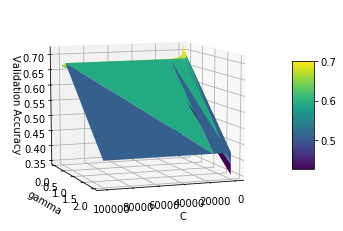

In [0]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(mean_acc['C'], mean_acc['Gamma'], mean_acc['ValAccuracy'], cmap=plt.cm.viridis, linewidth=0.2)
ax.view_init(10, 70)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.set_xlabel('C')
ax.set_ylabel('gamma')
ax.set_zlabel('Validation Accuracy')
ax.dist = 10
plt.show()


### Secondary Grid search

Repeat the grid search, but test a smaller range of values, near the best value found earlier.

Again, still use Cross Validation on the Training set only here. 

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
## Grid Searching:
c_list = np.linspace(1, 20,num=10)
gamma_list = np.linspace(0.01, 0.1, num = 10)
dec_funcs = ['ovr', 'ovo']
n_folds = 5

skf = StratifiedKFold(n_splits=n_folds)


In [0]:
results = pd.DataFrame()

In [0]:
# get training and validation indices for cross-validation
# (this is for hyper-parameter optimization, so using only the Training set)

fold = 0
for trn_ix, val_ix in skf.split(X_train, y_train):
  for c in c_list:
    for gamma in gamma_list:
      for dec in dec_funcs:
        clf = SVC(C=c, kernel='rbf', gamma=gamma, decision_function_shape=dec)
        clf.fit(X_train[trn_ix], y_train[trn_ix])
        accuracy = clf.score(X_train[val_ix], y_train[val_ix])
        results = results.append({'Fold': fold, 
                                  'Gamma': gamma, 'C': c, 
                                  'DecFunc': dec,
                                  'ValAccuracy': accuracy}, ignore_index=True)

  fold += 1  

In [0]:
results.loc[results['ValAccuracy'] == results['ValAccuracy'].max()]

In [0]:
results.to_csv('svm_raw_grid_results2.csv', header=True, index=False)

In [0]:
results = pd.read_csv('svm_raw_grid_results2.csv', index_col=None, header=0)

In [0]:
mean_acc = results.groupby(['C', 'Gamma', 'DecFunc'], as_index=False).mean().drop('Fold', axis=1)

In [0]:
mean_acc[mean_acc['ValAccuracy'] == mean_acc['ValAccuracy'].max()]

,C,Gamma,DecFunc,ValAccuracy
30,3.111111,0.06,ovo,0.725113
31,3.111111,0.06,ovr,0.725113


In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

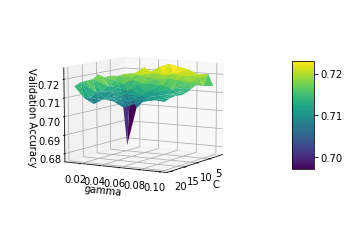

In [0]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(mean_acc['C'], mean_acc['Gamma'], mean_acc['ValAccuracy'], cmap=plt.cm.viridis, linewidth=0.2)
ax.view_init(10, 750)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.set_xlabel('C')
ax.set_ylabel('gamma')
ax.set_zlabel('Validation Accuracy')
ax.dist = 13
plt.show()


### Model Evaluation

In [0]:
#clf = SVC(C=4, kernel = 'rbf', gamma = 0.03)
clf = SVC(C=3, kernel = 'rbf', gamma = 0.06)
clf.fit(X_train, y_train)


SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.06, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
clf.score(X_train, y_train)

0.9600967351874244

In [0]:
# get test accuracy:
clf.score(X_test, y_test)

0.7371885284438175

In [0]:
# get test set predictions:
y_hat = clf.predict(X_test)

In [0]:
# create confusion matrix:
cf = pd.DataFrame(confusion_matrix(y_test,y_hat))
cf.columns = le.inverse_transform(cf.columns)
cf.index = le.inverse_transform(cf.index)

In [0]:
cf

,negative,neutral,positive
negative,508,140,61
neutral,95,518,96
positive,62,105,542


In [0]:
prfs = precision_recall_fscore_support(y_test,y_hat, average='macro')

print("Precision:\t{0:.4f} \nRecall: \t{1:.4f} \nF Score: \t{2:.4f}".format(prfs[0],prfs[1],prfs[2]))

Precision:	0.7394 
Recall: 	0.7372 
F Score: 	0.7377
